In [209]:
import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt

In [210]:
rm = pyvisa.ResourceManager(); print(rm) # see directory for reource manager (?)
res = rm.list_resources(); print("Resources : ", res) # See which resources are available (USB etc.)
USB_resource = res[0]
inst = rm.open_resource(USB_resource) # In my case the index 0 is the USB device
device = inst.query("*IDN?") # Then, you query the device with the following message: '\*IDN?'. Which is the standard GPIB message for “what are you?”

Resource Manager of Visa Library at C:\WINDOWS\system32\visa32.dll
Resources :  ('USB0::0x2A8D::0x1766::MY56311274::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR')


In [ ]:

def device_info(instrument):
    """
    Queries and prints information about the connected instrument.

    Args:
        instrument (pyvisa.resources.Resource): The PyVISA instrument object.
    """
    device = instrument.query('*IDN?')
    brand, model, SN, info = device.split(',')
    print(f"Connected to :")
    print(f"        Brand : {brand}")
    print(f"        Model : {model}")
    print(f"Serial/Number : {SN},  {info}")

In [64]:
device_info(inst)

Connected to :
        Brand : KEYSIGHT TECHNOLOGIES
        Model : DSO-X 3024T
Serial/Number : MY56311274,  07.20.2017102614



In [ ]:
def scope_settings(scope, which="acq"):
    """
    Applies general scope settings like waveform intensity, channel scale,
    impedance, and offset.

    Args:
        scope (pyvisa.resources.Resource): The PyVISA instrument object for the oscilloscope.
        which (str, optional): Determines offset setting. "acq" for 0V offset,
                                "display" or "disp" for pre-defined offsets. Defaults to "acq".
    Raises:
        ValueError: If 'which' argument is not 'acq' or 'disp'.
    """
    scope.write(":DISPlay:INTensity:WAVeform 90") # how visible is the ave on oscilloscope
    for channel, offset in zip(range(1,4), [-6, 0, 6]):
        scope.write(f":CHANnel{channel}:SCALe 5 V") # Scale amplitude
        scope.write(f":CHANnel{channel}:IMPedance FIFTY") # Set impedance 'FIFTY' for 50 Ohm, or ONEM for 1 mega Ohm

        # Set offsets
        if which == "acq":
            scope.write(f":CHANnel{channel}:OFFset 0 V")
        elif which == "display" or which =="disp":
            scope.write(f":CHANnel{channel}:OFFset {offset}")
        else:
            raise ValueError(f"    arg 'wich' has to be   'acq'  for acquire, or  'disp'  for display")

In [204]:
def acq_data(resource_name, timebase_scale = 100e-6):
    """
    Connects to the oscilloscope, configures it for a single acquisition
    by setting the specified timebase scale, and then extracts waveform data
    from three specified channels.

    Args:
        resource_name (str): The VISA address of the oscilloscope.
        timebase_scale (float): The horizontal scale in seconds per division (s/div) [default: 100e-6s].

    Returns:
        dict: A dictionary where keys are channel names ('CHANnel1', 'CHANnel2', 'CHANnel3')
              and values are dictionaries containing 'raw_data', 'voltages', 'times',
              and 'preamble' information for that channel.
              Returns an empty dictionary if connection or acquisition fails.
    """
    rm = None
    scope = None
    acquired_data = {}
    
    # Define the channels to read directly within the function
    CHANNELS_TO_READ = ["CHANnel1", "CHANnel2", "CHANnel3"] 
    DATATYPE = "h"
    try:
        rm = pyvisa.ResourceManager()
        print(f"Attempting to connect to: {resource_name}")
        scope = rm.open_resource(resource_name)
        
        device_info(scope) # Call user's device_info function
        
        # scope.write(":AUToscale")
        scope.write("*CLS") # Clear any previous errors
        time.sleep(0.1)
        scope.write(":STOP") # Ensure scope is stopped before configuration
        time.sleep(0.1)
        
        scope_settings(scope, which="acq") # Call user's scope_settings function for acquisition settings
        
        # --- Configure Waveform Transfer ---
        scope.write(":WAVeform:FORMat BINary")
        
        # --- Set Timebase Scale (from argument) ---
        print(f"Setting Timebase Scale to: {timebase_scale:.2e} s/div.")
        scope.write(f":TIMebase:SCALe {timebase_scale}") # Set horizontal scale based on argument
        
         # Configure Trigger as per your provided snippet
        scope.write(":TRIGger:SOURce CHANnel3") # Heralding signal
        scope.write(":TRIGger:LEVel 2 V") # Trigger voltage
        scope.write(":TRIGger:EDGE:SLOPe POSitive") # Positive or negative slope
        
        # Set to SINGLE trigger mode: Acquire one waveform and then stop.
        scope.write(":TRIGger:MODE SINGle") 
        scope.write(":ACQuire:TYPE NORMal") # Set acquisition type to normal

        print("\nOscilloscope configured. Waiting for trigger for single acquisition...")
        
        # Arm the single acquisition
        scope.write(":SINGle")
        
        # Wait for the acquisition to complete.
        # `*OPC?` ensures the previous command (single acquisition) is fully done.
        print("Waiting for acquisition to complete...")
        scope.query("*OPC?") 
        print("Single acquisition complete. Oscilloscope is stopped and holding data.")
        
        
        # --- Oscilloscope is now stopped and holding the "screenshot" data ---
        # --- Extract Data from all channels ---
        acquired_data = {}
        for channel in CHANNELS_TO_READ:
            print(f"\n  Extracting data from {channel}...")
            scope.write(f":WAVeform:SOURce {channel}")
            time.sleep(0.05) # Give the scope a moment to switch channels context

            # Query preamble for the current channel
            # This preamble reflects the *actual* acquisition settings (sample rate, record length, etc.)
            preamble_string = scope.query(":WAVeform:PREamble?")
            preamble_list = preamble_string.split(',')    
            print(f"    Preamble for {channel}: {preamble_list}") # Print the list for inspection

            try:
                num_points_actual = int(float(preamble_list[2]))      # Total number of points acquired
                x_increment_actual = float(preamble_list[4]) # Actual time per point (1/SampleRate_Actual)
                x_origin_actual = float(preamble_list[5])    # Start time of the waveform
                y_increment_actual = float(preamble_list[7]) # Volts per raw data unit
                y_origin_actual = float(preamble_list[8])    # Vertical offset in Volts
                y_reference_actual = float(preamble_list[9]) # Vertical reference in raw units
                print(f"    Actual Acq: N_pts={num_points_actual}, Xinc={x_increment_actual:.2e}s, Yinc={y_increment_actual:.2e}V")
            except (IndexError, ValueError) as e:
                print(f"    ERROR: Failed to parse preamble for {channel}. Check manual and its structure. {e}")
                raise # Critical error, cannot interpret data without this
            
            # Read raw binary waveform data for the entire record
            raw_data = scope.query_binary_values(
                ":WAVeform:DATA?",
                datatype=DATATYPE,
                container=np.array,
                # is_big_endian=IS_BIG_ENDIAN # Uncomment if you defined IS_BIG_ENDIAN
            )
            print(f"    Raw data points extracted from {channel}: {len(raw_data)}")

            if len(raw_data) == 0:
                print(f"    WARNING: No data received from {channel}. Check acquisition and trigger settings.")
                continue # Skip processing for this channel if no data
                
            # Convert raw data to actual voltage values
            voltages = y_origin_actual + (raw_data - y_reference_actual)*y_increment_actual 

            # Create the time axis for this waveform
            times = x_origin_actual + np.arange(0, len(voltages))*x_increment_actual

            acquired_data[channel] = {
                'raw_data': raw_data,
                'voltages': voltages,
                'times': times,
                'preamble': {
                    'num_points': num_points_actual,
                    'x_increment': x_increment_actual,
                    'x_origin': x_origin_actual,
                    'y_increment': y_increment_actual,
                    'y_origin': y_origin_actual,
                    'y_reference': y_reference_actual
                }
            }
    
        
    except pyvisa.errors.VisaIOError as e:
        print(f"\nVISA Error: {e}")
        print("Please check connection and settings. Common issues:")
        print("  - Oscilloscope is not connected or powered on.")
        print("  - 'OSCILLOSCOPE_VISA_ADDRESS' is incorrect. Use 'rm.list_resources()' to verify.")
        print("  - VISA backend (NI-VISA, pyvisa-py) is not installed or configured.")
        print("  - The command to query memory depth might be incorrect for your scope.")
        print("  - The desired sample rate might be too high for the scope's capabilities.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
    finally:
        if scope and scope.session:
            scope.write(":RUN") # Return to run mode for live viewing
            scope.close()
            print("\nConnection closed.")
        
    return acquired_data
test = acq_data(USB_resource, timebase_scale=10e-6)

Attempting to connect to: USB0::0x2A8D::0x1766::MY56311274::INSTR
Connected to :
        Brand : KEYSIGHT TECHNOLOGIES
        Model : DSO-X 3024T
Serial/Number : MY56311274,  07.20.2017102614

Setting Timebase Scale to: 1.00e-05 s/div.

Oscilloscope configured. Waiting for trigger for single acquisition...
Waiting for acquisition to complete...
Single acquisition complete. Oscilloscope is stopped and holding data.

  Extracting data from CHANnel1...
    Preamble for CHANnel1: ['+4', '+0', '+62500', '+1', '+1.60000000E-009', '-5.00000000E-005', '+0', '+7.85175900E-004', '+0.0E+000', '+32768\n']
    Actual Acq: N_pts=62500, Xinc=1.60e-09s, Yinc=7.85e-04V
    Raw data points extracted from CHANnel1: 437499

  Extracting data from CHANnel2...
    Preamble for CHANnel2: ['+4', '+0', '+62500', '+1', '+1.60000000E-009', '-5.00000000E-005', '+0', '+7.85175900E-004', '+0.0E+000', '+32768\n']
    Actual Acq: N_pts=62500, Xinc=1.60e-09s, Yinc=7.85e-04V
    Raw data points extracted from CHANnel2

In [206]:
for key in test:
    print(key)

CHANnel1
CHANnel2
CHANnel3


In [207]:
def extract_to_numpy_array(acquired_data: dict, channel_order: list = None) -> np.ndarray:
    """
    Extracts time and voltage data from the acquired_data dictionary and
    formats it into a single NumPy array of shape (N, M+1), where M is the
    number of channels.

    The first column is Time (s), followed by voltages from the specified channels.
    Assumes that channels within acquired_data are time-synchronized.

    Args:
        acquired_data (dict): The dictionary returned by acq_data.
        channel_order (list, optional): A list of channel names defining the order
                                        of voltage columns in the output array.
                                        Defaults to ['CHANnel1', 'CHANnel2', 'CHANnel3'].

    Returns:
        np.ndarray: A 2D NumPy array of shape (N, M+1) with the combined data.
                    Returns None if data is inconsistent or missing.
    """
    if not acquired_data:
        print("Error: acquired_data dictionary is empty. No data to process.")
        return None

    if channel_order is None:
        channel_order = ['CHANnel1', 'CHANnel2', 'CHANnel3'] 
    
    # Check if all required channels are present and have 'voltages' and 'times'
    for ch in channel_order:
        if ch not in acquired_data or 'voltages' not in acquired_data[ch] or 'times' not in acquired_data[ch]:
            print(f"Error: Missing or incomplete data for {ch} in acquired_data.")
            return None

    # Get the time array from the first channel (all channels share the same timebase in a single shot)
    time_array = acquired_data[channel_order[0]]['times']
    N = len(time_array)

    # Verify consistent number of points across all channels (should be true for single shot)
    for ch in channel_order:
        if len(acquired_data[ch]['voltages']) != N:
            print(f"Error: Inconsistent number of data points. {ch} has {len(acquired_data[ch]['voltages'])} points, expected {N}.")
            return None

    # Extract voltage arrays in the desired order
    voltage_columns = [acquired_data[ch]['voltages'] for ch in channel_order]

    # Stack the time array and voltage columns into a (N, M+1) NumPy array
    combined_data_array = np.column_stack((time_array, *voltage_columns))

    print(f"\nSuccessfully extracted data to NumPy array of shape: {combined_data_array.shape}")
    return combined_data_array

data = extract_to_numpy_array(test)


Successfully extracted data to NumPy array of shape: (437499, 4)


In [219]:
with np.printoptions(formatter={"all": lambda x: f"{x:.3f}"}):
    print(data[:20, :])

[[-0.000 -15.643 -15.643 -15.241]
 [-0.000 -16.044 -16.044 -16.044]
 [-0.000 -16.042 -16.042 -16.041]
 [-0.000 -15.038 -15.038 -16.042]
 [-0.000 -16.604 -16.604 -16.604]
 [-0.000 -16.043 -16.043 -16.043]
 [-0.000 -16.846 -16.846 -16.846]
 [-0.000 -16.055 -15.643 -14.839]
 [-0.000 -16.044 -16.044 -16.044]
 [-0.000 -16.043 -16.042 -16.040]
 [-0.000 -16.043 -15.038 -15.037]
 [-0.000 -17.006 -16.604 -16.604]
 [-0.000 -16.043 -16.043 -16.043]
 [-0.000 -16.847 -16.846 -16.846]
 [-0.000 -15.643 -15.241 -15.643]
 [-0.000 -16.044 -16.044 -16.044]
 [-0.000 -16.042 -16.041 -16.042]
 [-0.000 -15.038 -16.042 -15.038]
 [-0.000 -16.604 -16.604 -16.604]
 [-0.000 -16.043 -16.043 -16.043]]


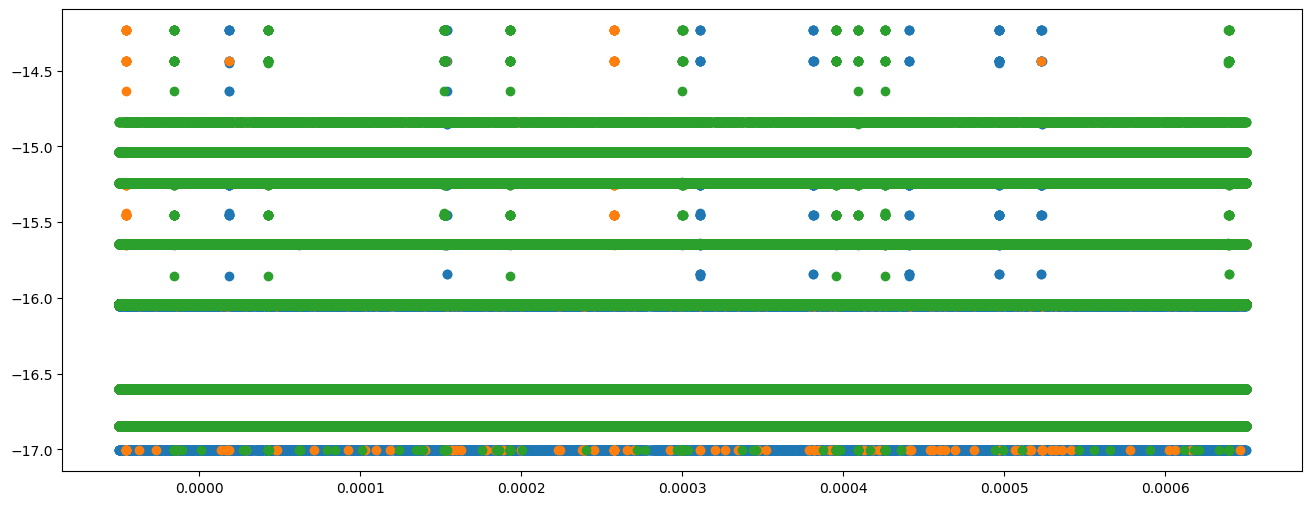

In [222]:
fig, ax = plt.subplots(figsize=(16,6))

for i in range(1,4):
    ax.scatter(data[:, 0], data[:, i], label=f"CHAN-{i}")

In [13]:
# for i in range(25):
#     # Connect to instrument
#     rm = pyvisa.ResourceManager()
#     scope = rm.open_resource('USB0::0x2A8D::0x1766::MY56311264::INSTR')  # Replace with your VISA address
#     scope.timeout = 5000  # Timeout in ms
#     scope.write(":TIMebase:RANGe 1") 
    
    
#     # Set acquisition mode to single
#     scope.write(":STOP")               # Make sure scope is stopped
#     scope.write(":SINGle")             # Run a single acquisition
#     time.sleep(0.2)                    # Wait briefly to ensure trigger
    
#     # Wait until acquisition is complete
#     while True:
#         done = scope.query(":OPER:COND?").strip()
#         if int(done) & 0b1 == 0:       # Bit 0 = acquisition in progress
#             break
#         time.sleep(0.05)
    
#     # Set common waveform settings
#     scope.write(":WAV:MODE NORM")
#     scope.write(":WAV:FORM BYTE")
#     points = 1000000
#     scope.write(f":WAV:POINTS {int(points)}")      # Set number of points
    
#     # Acquire data from Channel 1
#     scope.write(":WAV:SOUR CHAN1")
#     raw_data1 = scope.query_binary_values(":WAV:DATA?", datatype='B', container=np.array)
    
#     # Acquire data from Channel 2
#     scope.write(":WAV:SOUR CHAN2")
#     raw_data2 = scope.query_binary_values(":WAV:DATA?", datatype='B', container=np.array)
    
#     # Convert raw data to voltage using preamble
#     x_increment = float(pre[4])
#     x_origin = float(pre[5])
#     y_increment = float(pre[7])
#     y_origin = float(pre[8])
#     y_ref = float(pre[9])
    
#     t = np.arange(len(raw_data1)) * x_increment + x_origin
#     voltage1 = (raw_data1 - y_ref) * y_increment + y_origin
#     voltage2 = (raw_data2 - y_ref) * y_increment + y_origin
    
#     # Simulated pulses on two channels (replace with actual data)
#     ch1 = voltage1
#     ch2 = voltage2
    
    
#     # Detect pulses using a threshold
#     threshold = 1.1
    
#     peaks1, properties1 = find_peaks(ch1, height=threshold)
#     peaks2, properties2 = find_peaks(ch2, height=threshold)
    
#     # Extract times of peaks
#     times1 = t[peaks1]
#     times2 = t[peaks2]
    
#     # Define coincidence window (±10 ns)
#     coincidence_window = 10e-9
    
#     # Compare each time in ch1 with ch2 to find coincidences
#     coincidences = []
#     for t1 in times1:
#         for t2 in times2:
#             if abs(t1 - t2) <= coincidence_window:
#                 coincidences.append((t1, t2))
    
#     print("Coincidence count:", len(coincidences))
    
#     # Add the coincidence count to the DataFrame
#     df.loc[len(df)] = [pol_A, qwp_a, pol_b, qwp_b, len(coincidences)]


VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.